In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in python modules
import math
import datetime
import warnings
warnings.filterwarnings(action='ignore')

# Python add-ons
import numpy as np
import pandas as pd
from statsmodels.api import qqplot

# Sandia pvlib-python
import pvlib

# Synthetic
import sys
sys.path.insert(1, '../../')
import src

# 1. Data

In [2]:
FILE = 'adelaide-60'

df = pd.read_csv(filepath_or_buffer=f'../data/{FILE}.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True)

# NaN
df = df.fillna(0)

# Ant data
df.loc[df['ghi_wm2'] <= 1.5, 'ghi_wm2'] = 0

df.head()

,ghi_wm2,tamb_c
timestamp,,
2020-01-01 00:00:00,0,17.2
2020-01-01 01:00:00,0,16.8
2020-01-01 02:00:00,0,16.3
2020-01-01 03:00:00,0,16.0
2020-01-01 04:00:00,0,15.8


# 2. Synthetic Irradiance Data Generation

## 2.1. Clear-Sky Index

According to **(Skartveit and Olseth, 1992)**, the clear-sky index ($k_c$) is the measured irradiance in the plane of array (in this case `ghi_wm2` data) normalized by the global irradiance (GHI) under clear sky conditions.

$$
k= \frac{H}{H_{cs}}
\tag{1}
$$

Where $H$ is the observed GHI in the plane of array, and $H_{cs}$ is the clear-sky GHI.

The main benefit is that the losses due to atmosphere are already accounted for as they are encompassed within clear-sky global horizontal irradiance ($H_{cs}$). This means that the losses described by the clear-sky index can be exclusively isolated to the influence of clouds. The clear-sky index, therefore, explains the optical losses associated to clouds.

The value of $k_c$ allows estimating the meteorological conditions of the day according to **(Larrañeta et al., 2015)**. Also, expressing irradiance in terms of $k_c$ is the closest approximation of stationarity with solar irradiance time series, according to (**Bright et al., 2021**). A stationary time series has the same mean, variance and auto-correlation over time.

**Note:** As the presence of clouds is not stationary (except over coarse temporal averages), and the indices represent losses due to clouds, a time series of $k_c$ are not perfectly stationary. That said, it effectively remove all influence of seasons and the daily curve of irradiance (from sunrise and sunset) from the time series (**Bright et al., 2021**).

In [3]:
# Location
latitude = -34.92
longitude = 138.61
tz = 'Australia/Adelaide'
altitude = 54 # [m]

location = pvlib.location.Location(latitude, longitude, tz, altitude)

In [4]:
# Clear-sky irradiance (Hcs)
RESOLUTION = int(pd.Series(df.index.values).diff().median().total_seconds()/60)

hcs = location.get_clearsky(times=pd.date_range(start=df.index[0] - datetime.timedelta(days=1, hours=0, minutes=30),
                            end=df.index[-1] + datetime.timedelta(days=1, hours=0, minutes=30),
                            freq=f'{RESOLUTION}min',
                            tz=tz),
                            model='ineichen')

hcs.index = hcs.index + datetime.timedelta(days=0, hours=9, minutes=0)
hcs.index = hcs.index.tz_convert(None)

hcs.head()

,ghi,dni,dhi
2019-12-30 22:00:00,0.0,0.0,0.0
2019-12-30 23:00:00,0.0,0.0,0.0
2019-12-31 00:00:00,0.0,0.0,0.0
2019-12-31 01:00:00,0.0,0.0,0.0
2019-12-31 02:00:00,0.0,0.0,0.0


Same as (**Bright et al., 2021**) described, at sunrise and sunset the values of irradiance are in the order of 0 - 10 W/m2, $k_c$ become very sensitive to discrepancies between clear-sky estimate and measurement. It is common in solar energy engineering to ignore the first 5° of solar elevation.

In [5]:
# Append clear-sky irradiance to main dataframe
df = pd.merge(df, hcs['ghi'], left_index=True, right_index=True)
df = df.rename(columns={'ghi': 'hcs_wm2'})

# Clear-sky index (kc) to main dataframe
df['kc'] = df['ghi_wm2'].values / df['hcs_wm2'].values

# Filters
## NaN
df['kc'] = df['kc'].fillna(1)

# Replace kc > 1
df.loc[df['kc'] > 1, 'kc'] = 1

df.head()

,ghi_wm2,tamb_c,hcs_wm2,kc
2020-01-01 00:00:00,0,17.2,0.0,1.0
2020-01-01 01:00:00,0,16.8,0.0,1.0
2020-01-01 02:00:00,0,16.3,0.0,1.0
2020-01-01 03:00:00,0,16.0,0.0,1.0
2020-01-01 04:00:00,0,15.8,0.0,1.0


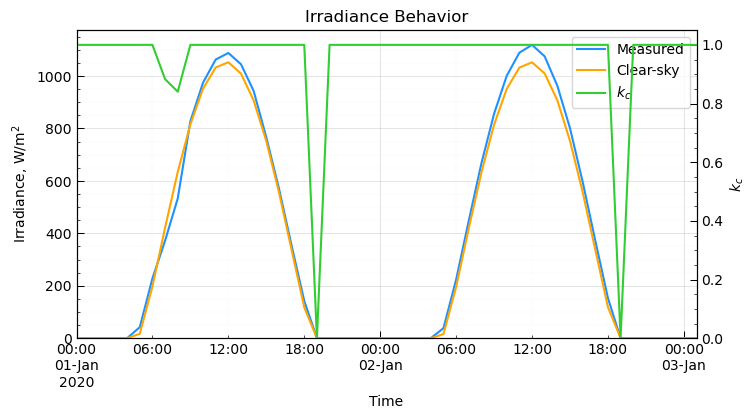

In [6]:
hor = 8
ver = 4
plt.figure(figsize=(hor, ver), dpi=100)

# GHI and Hcs
df['ghi_wm2'][0:50].plot(color='dodgerblue', label='Measured', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)
df['hcs_wm2'][0:50].plot(color='orange', label='Clear-sky', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)

plt.rcParams['axes.axisbelow'] = True

plt.title('Irradiance Behavior')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.legend(loc='best', fontsize=9)
plt.tight_layout;

# kc
df['kc'][0:50].plot(color='limegreen', label='$k_c$', secondary_y=True, xlabel='Time', ylabel='$k_c$', legend=True, mark_right=False)

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.tight_layout;

## 2.2. `analysis`: Function to extract descriptive statistics from irradiance data

In [7]:
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

INVERSE_MONTHS = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

MULTIINDEX = [(i,j) for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

XTICKS = np.arange(start=0, stop=len(TIMES), step=5)
LABELS = [TIMES[i] for i in XTICKS]

### 2.2.1. Shapiro-Wilk, Anderson-Darling and Kolmogorov-Smirnov tests

In [8]:
LOOP_YEARS = df.index.year.unique().values
LOOP_MONTHS = df.index.month.unique().values
LOOP_SC = ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']

LOOP_ANALYSIS = {}

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}'] = src.utils.analysis(df=df, year=i, month=j, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=False)

In [9]:
# For high resolution (e.g., 5 min), this cell takes ~10 min to run

DISTRIBUTIONS = pd.DataFrame()

for z in LOOP_ANALYSIS.keys():
    i = int(z[3:7]) # Year
    j = INVERSE_MONTHS[z[0:3]] # Month

    for k in LOOP_SC:
        df_to_check = LOOP_ANALYSIS[z]['bootstrap'][k]

        if (df_to_check.empty != True) and (len(df_to_check) >= 3):
            aux_df = pd.DataFrame(data={'year':i,
                                        'month': j,
                                        'sc': k,
                                        'shapiro_wilk': [src.utils.shapiro_wilk(data=d) for d in df_to_check.T.values],
                                        'anderson_darling': [src.utils.anderson_darling(data=d) for d in df_to_check.T.values],
                                        'lognormal_test': [src.utils.lognormal_test(data=d) for d in df_to_check.T.values]},
                                  index=df_to_check.columns).iloc[TIMES.index('6:00'):TIMES.index('18:00'),:] # 6:15 to 17:45h

            DISTRIBUTIONS = pd.concat([DISTRIBUTIONS, aux_df])

DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/distributions.csv')

In [10]:
DISTRIBUTIONS.describe()

,year,month,shapiro_wilk,anderson_darling,lognormal_test
count,300.0,300.000000,300.000000,300.000000,300.000000
mean,2020.0,6.760000,0.286900,0.950000,0.173600
std,0.0,3.541781,0.343929,0.218309,0.267535
min,2020.0,1.000000,-0.000000,0.000000,0.000000
25%,2020.0,4.000000,0.000000,1.000000,0.000000
50%,2020.0,7.000000,0.100000,1.000000,0.000000
75%,2020.0,10.000000,0.520000,1.000000,0.280000
max,2020.0,12.000000,1.000000,1.000000,1.000000


In [11]:
# Gaussian distribution
complete_gaussian = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['anderson_darling'] == 1)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
complete_lognormal = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] <= 0.05) & (DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

# Most likely lognormal distribution
possible_lognormal = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=possible_lognormal, decimals=2)}% of the total data most likely behaves as a lognormal distribution.')

51.33% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
4.33% of the total data behaves as a lognormal distribution.
36.67% of the total data most likely behaves as a lognormal distribution.


In [12]:
GROUPED_DISTRIBUTIONS = DISTRIBUTIONS.groupby(by=['year', 'month', 'sc']).mean().round(decimals=2).astype({'anderson_darling': int})
GROUPED_DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/grouped.csv')

In [13]:
GROUPED_DISTRIBUTIONS.describe()

,shapiro_wilk,anderson_darling,lognormal_test
count,25.000000,25.000000,25.000000
mean,0.287200,0.640000,0.174800
std,0.205356,0.489898,0.187308
min,0.000000,0.000000,0.000000
25%,0.110000,0.000000,0.020000
50%,0.240000,1.000000,0.130000
75%,0.470000,1.000000,0.270000
max,0.660000,1.000000,0.600000


In [14]:
# Gaussian distribution
grouped_gaussian = (len(GROUPED_DISTRIBUTIONS[(GROUPED_DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (GROUPED_DISTRIBUTIONS['anderson_darling'] == 1)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
grouped_lognormal = (len(GROUPED_DISTRIBUTIONS[(GROUPED_DISTRIBUTIONS['shapiro_wilk'] <= 0.05) & (GROUPED_DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

48.0% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
0.0% of the total data behaves as a lognormal distribution.


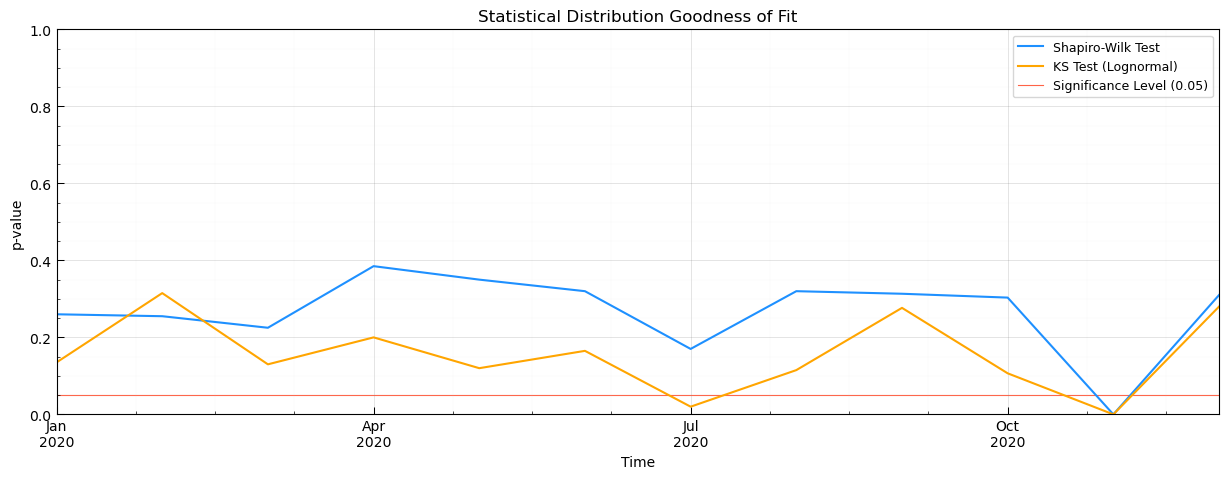

In [15]:
aux_grouped_distributions = GROUPED_DISTRIBUTIONS.groupby(['year', 'month']).mean()
x_axis = [f'{MONTHS[str(i[1])]}\n{i[0]}' for i in aux_grouped_distributions.index]

XTICKS = np.arange(start=0, stop=len(x_axis), step=3)
LABELS = [x_axis[i] for i in XTICKS]

hor = 15
ver = 5
plt.figure(figsize=(hor,ver), dpi=100)

plt.plot(aux_grouped_distributions['shapiro_wilk'].values, color='dodgerblue', label='Shapiro-Wilk Test')
plt.plot(aux_grouped_distributions['lognormal_test'].values, color='orange', label='KS Test (Lognormal)')
plt.axhline(y=0.05, linewidth=0.8, color='tomato', label='Significance Level (0.05)', zorder=0)

plt.title(f'Statistical Distribution Goodness of Fit')
plt.ylabel('p-value')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, 1)
plt.xlim(0, len(aux_grouped_distributions)-1)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.2. Histogram (Gaussian or lognormal distributions)

In [16]:
# Constants
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

XTICKS = np.arange(start=0, stop=len(TIMES), step=10)
LABELS = [TIMES[i] for i in XTICKS]

# src.utils.analysis function example
YEAR = 2020
MONTH = 1

ANALYSIS = src.utils.analysis(df=df, year=YEAR, month=MONTH, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=False)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

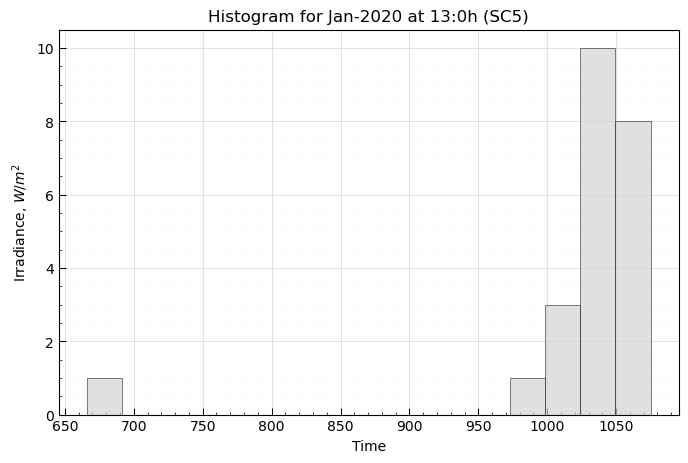

In [17]:
HOUR = 13
MINUTE = 0
SC = 'sc5'

df_to_hist = df[(df.index.year == YEAR) & (df.index.month == MONTH) & (df.index.day.isin(ANALYSIS['bootstrap'][SC].index)) & (df.index.hour == HOUR) & (df.index.minute == MINUTE)]['ghi_wm2'].values

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.hist(x=df_to_hist, bins='auto', color='lightgrey', alpha=0.7, edgecolor='black', linewidth=0.5);

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.3. QQ-Plots

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

<Figure size 800x500 with 0 Axes>

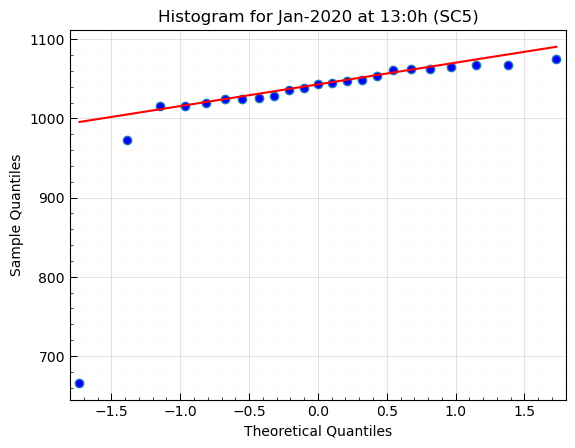

In [18]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

qqplot(df_to_hist, line='q', markerfacecolor='blue')

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
#plt.ylabel()
#plt.xlabel()
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(None, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

# 3. Validations

In [19]:
SYNTHETIC = {'stochastic': {}, 'bootstrap': {}}
IC = 0.95
RUNS = 5

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        for k in LOOP_SC:
            # Stochastic
            SYNTHETIC['stochastic'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                             irradiance_column='ghi_wm2',
                                                                                             year=i,
                                                                                             month=j,
                                                                                             sky_condition=k,
                                                                                             method='stochastic',
                                                                                             IC=IC,
                                                                                             resolution=RESOLUTION,
                                                                                             runs=RUNS)
            # Bootstrap
            SYNTHETIC['bootstrap'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                            irradiance_column='ghi_wm2',
                                                                                            year=i,
                                                                                            month=j,
                                                                                            sky_condition=k,
                                                                                            method='bootstrap',
                                                                                            IC=IC,
                                                                                            resolution=RESOLUTION,
                                                                                            runs=RUNS)

## 3.1. Variability metrics

In [20]:
VARIABILITY_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'standard_deviation_increments': [[], []],
                    'stability_index': [[], []],
                    'iccdf': [[], []],
                    'variability_index': [[], []]}

        for _ in range(RUNS):
            try:
                aux = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1)
                sample1 = aux.values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Standard deviation of increments (SDI)
                metrics['standard_deviation_increments'][0].append(src.metrics.standard_deviation_increments(data=sample1))
                metrics['standard_deviation_increments'][1].append(src.metrics.standard_deviation_increments(data=sample2))

                # Stability index (SI)
                metrics['stability_index'][0].append(src.metrics.stability_index(data=sample1, threshold=100))
                metrics['stability_index'][1].append(src.metrics.stability_index(data=sample2, threshold=100))

                # Integrated complementary cumulative distribution function (ICCDF)
                metrics['iccdf'][0].append(src.metrics.iccdf(data=sample1))
                metrics['iccdf'][1].append(src.metrics.iccdf(data=sample2))

                # Variability index (VI)
                temp = df.loc[(df.index.year == i) & (df.index.month == j) & (df.index.day == aux.columns[0])]
                metrics['variability_index'][0].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample1, hcs=temp['hcs_wm2'].values).mean())
                metrics['variability_index'][1].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample2, hcs=temp['hcs_wm2'].values).mean())

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_], axis=1)

        VARIABILITY_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [21]:
metrics_stochastic = pd.DataFrame(VARIABILITY_METRICS['stochastic']).T
metrics_bootstrap = pd.DataFrame(VARIABILITY_METRICS['bootstrap']).T

# Stochastic
pe_stochastic = metrics_stochastic * 0

pe_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_stochastic.index]
pe_stochastic['sc'] = [i[8:11] for i in pe_stochastic.index]

for i in metrics_stochastic.columns:
    pe_stochastic[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_stochastic[i]]

pe_stochastic = pe_stochastic.fillna(0)

# Bootstrap
pe_bootstrap = metrics_bootstrap * 0

pe_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_bootstrap.index]
pe_bootstrap['sc'] = [i[8:11] for i in pe_bootstrap.index]

for i in metrics_bootstrap.columns:
    pe_bootstrap[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_bootstrap[i]]

pe_bootstrap = pe_bootstrap.fillna(0)

In [22]:
# Percentage error monthly average
VM_STOCHASTIC_MONTH = pe_stochastic.groupby(by='month').mean().round(decimals=2)
VM_BOOTSTRAP_MONTH = pe_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
VM_STOCHASTIC_SC = pe_stochastic.groupby(by='sc').mean().round(decimals=2)
VM_BOOTSTRAP_SC = pe_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [23]:
# Download
VM_STOCHASTIC_MONTH.to_csv(f'../metrics/variability/{FILE}/stochastic_month.csv')
VM_BOOTSTRAP_MONTH.to_csv(f'../metrics/variability/{FILE}/bootstrap_month.csv')
VM_STOCHASTIC_SC.to_csv(f'../metrics/variability/{FILE}/stochastic_sc.csv')
VM_BOOTSTRAP_SC.to_csv(f'../metrics/variability/{FILE}/bootstrap_sc.csv')

In [24]:
VM_STOCHASTIC_MONTH.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index
count,12.000000,12.0,12.00000,12.000000
mean,7.700833,0.0,16.69500,3.339167
std,3.465834,0.0,16.73195,1.698446
min,1.070000,0.0,0.90000,1.230000
25%,6.092500,0.0,4.70750,2.057500
50%,6.965000,0.0,11.31000,2.925000
75%,9.490000,0.0,21.34250,4.660000
max,13.540000,0.0,58.02000,6.110000


In [25]:
VM_BOOTSTRAP_MONTH.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index
count,12.000000,12.0,12.000000,12.000000
mean,7.401667,0.0,63.431667,2.674167
std,2.622542,0.0,194.402603,1.655335
min,3.010000,0.0,1.620000,0.740000
25%,5.797500,0.0,3.795000,1.577500
50%,7.720000,0.0,6.080000,2.135000
75%,9.120000,0.0,7.540000,3.317500
max,11.310000,0.0,680.280000,5.860000


In [26]:
VM_STOCHASTIC_SC.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index,month
count,5.000000,5.0,5.000000,5.000000,5.0
mean,7.702000,0.0,16.694000,3.342000,6.5
std,4.307542,0.0,14.346774,2.321437,0.0
min,3.000000,0.0,1.150000,0.670000,6.5
25%,4.720000,0.0,5.150000,1.630000,6.5
50%,7.340000,0.0,14.700000,3.500000,6.5
75%,9.410000,0.0,27.950000,4.330000,6.5
max,14.040000,0.0,34.520000,6.580000,6.5


In [27]:
VM_BOOTSTRAP_SC.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index,month
count,5.000000,5.0,5.00000,5.000000,5.0
mean,7.402000,0.0,63.43200,2.674000,6.5
std,4.002714,0.0,126.50373,1.953377,0.0
min,1.990000,0.0,1.22000,0.430000,6.5
25%,4.340000,0.0,3.33000,0.830000,6.5
50%,9.680000,0.0,6.46000,3.210000,6.5
75%,9.780000,0.0,16.67000,4.110000,6.5
max,11.220000,0.0,289.48000,4.790000,6.5


## 3.2. Comparison of statistical distributions

In [28]:
STATISTICAL_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'kolmogorov_smirnov': [],
                   'kullback_leibler_divergence': [],
                   'overlapping_coefficient': []}

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Kolmogorov-Smirnov Test (KS)
                metrics['kolmogorov_smirnov'].append(src.metrics.kolmogorov_smirnov(sample1=sample1, sample2=sample2))

                # Kullback-Leibler Divergence (KLD)
                metrics['kullback_leibler_divergence'].append(src.metrics.kullback_leibler_divergence(sample1=sample1, sample2=sample2))

                # Overlapping coefficient (OVC)
                metrics['overlapping_coefficient'].append(src.metrics.overlapping_coefficient(sample1=sample1, sample2=sample2))

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_])

        STATISTICAL_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [29]:
ovc = pd.Series([STATISTICAL_METRICS['bootstrap'][i]['overlapping_coefficient'] for i in STATISTICAL_METRICS['bootstrap'].keys()])
ovc.describe()

count    47.000000
mean      0.734752
std       0.167591
min       0.500000
25%       0.608333
50%       0.683333
75%       0.958333
max       1.000000
dtype: float64

In [30]:
# Stochastic
metrics_stochastic = pd.DataFrame(STATISTICAL_METRICS['stochastic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(STATISTICAL_METRICS['bootstrap']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [31]:
# Monthly average
SM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
SM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Sky condition average
SM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
SM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [32]:
# Download
SM_STOCHASTIC_MONTH.to_csv(f'../metrics/statistical/{FILE}/stochastic_month.csv')
SM_BOOTSTRAP_MONTH.to_csv(f'../metrics/statistical/{FILE}/bootstrap_month.csv')
SM_STOCHASTIC_SC.to_csv(f'../metrics/statistical/{FILE}/stochastic_sc.csv')
SM_BOOTSTRAP_SC.to_csv(f'../metrics/statistical/{FILE}/bootstrap_sc.csv')

In [33]:
SM_STOCHASTIC_MONTH.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient
count,12.000000,12.000000,12.000000
mean,0.728333,0.139167,0.550833
std,0.169053,0.093853,0.133380
min,0.530000,0.050000,0.360000
25%,0.590000,0.087500,0.455000
50%,0.715000,0.105000,0.540000
75%,0.842500,0.150000,0.660000
max,0.990000,0.330000,0.780000


In [34]:
SM_BOOTSTRAP_MONTH.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient
count,12.000000,12.000000,12.000000
mean,0.750000,0.162500,0.575000
std,0.178733,0.087191,0.140809
min,0.550000,0.090000,0.360000
25%,0.590000,0.107500,0.460000
50%,0.725000,0.130000,0.545000
75%,0.955000,0.185000,0.717500
max,0.990000,0.400000,0.760000


In [35]:
SM_STOCHASTIC_SC.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient,month
count,5.000000,5.000000,5.000000,5.0
mean,0.728000,0.138000,0.552000,6.5
std,0.194345,0.055408,0.126768,0.0
min,0.420000,0.060000,0.350000,6.5
25%,0.660000,0.110000,0.520000,6.5
50%,0.800000,0.140000,0.580000,6.5
75%,0.870000,0.190000,0.640000,6.5
max,0.890000,0.190000,0.670000,6.5


In [36]:
SM_BOOTSTRAP_SC.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient,month
count,5.000000,5.000000,5.000000,5.0
mean,0.752000,0.160000,0.578000,6.5
std,0.217187,0.086891,0.120913,0.0
min,0.410000,0.050000,0.380000,6.5
25%,0.660000,0.100000,0.580000,6.5
50%,0.880000,0.160000,0.580000,6.5
75%,0.900000,0.240000,0.660000,6.5
max,0.910000,0.250000,0.690000,6.5


## 3.3. Energy production

In [37]:
INVERTER = pvlib.pvsystem.retrieve_sam(name='CECInverter')['ABB__TRIO_50_0_TL_OUTD_US_480__480V_']
MODULE = pvlib.pvsystem.retrieve_sam(name='CECMod')['LG_Electronics_Inc__LG400N2W_A5']
MPS = 16 # Modules per string
SPI = 8 # Strings per inverter
LOSS = 26.9

In [38]:
# Module temperature with NOCT equation
df['tmod_c'] = df['tamb_c'] + (((MODULE['T_NOCT'] - 20)/800) * df['ghi_wm2'])

TMOD = np.mean(df['tmod_c'].loc[(df.index.hour >= 6) & (df.index.hour < 18)])

In [39]:
ENERGY_METRIC = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = [[], []]

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Energy production
                metrics[0].append(src.metrics.energy(irradiance=sample1, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))
                metrics[1].append(src.metrics.energy(irradiance=sample2, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))

            except:
                pass

        ENERGY_METRIC[m][f'{MONTHS[str(j)]}{i}-{k}'] = np.mean(metrics, axis=1)

In [40]:
# Stochastic
metrics_stochastic = pd.DataFrame(ENERGY_METRIC['stochastic'], index=['real', 'synthetic']).T

metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]

metrics_stochastic['percentage_error'] = src.metrics.percentage_error(target=metrics_stochastic['real'], predicted=metrics_stochastic['synthetic'])

metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(ENERGY_METRIC['bootstrap'], index=['real', 'synthetic']).T

metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]

metrics_bootstrap['percentage_error'] = src.metrics.percentage_error(target=metrics_bootstrap['real'], predicted=metrics_bootstrap['synthetic'])

metrics_bootstrap = metrics_bootstrap.fillna(0)

In [41]:
# Percentage error monthly average
EM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
EM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
EM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
EM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [42]:
# Download
EM_STOCHASTIC_MONTH.to_csv(f'../metrics/energy/{FILE}/stochastic_month.csv')
EM_BOOTSTRAP_MONTH.to_csv(f'../metrics/energy/{FILE}/bootstrap_month.csv')
EM_STOCHASTIC_SC.to_csv(f'../metrics/energy/{FILE}/stochastic_sc.csv')
EM_BOOTSTRAP_SC.to_csv(f'../metrics/energy/{FILE}/bootstrap_sc.csv')

In [43]:
EM_STOCHASTIC_MONTH.describe()

,real,synthetic,percentage_error
count,12.0000,12.000000,12.000000
mean,98456.6375,96363.243333,6.724167
std,50409.7429,49362.858214,2.866923
min,31211.3800,29590.040000,3.770000
25%,64549.5025,64995.412500,5.030000
50%,84881.5250,83727.750000,6.230000
75%,142602.5775,128941.185000,7.035000
max,175222.1900,175101.310000,14.140000


In [44]:
EM_BOOTSTRAP_MONTH.describe()

,real,synthetic,percentage_error
count,12.000000,12.000000,12.000000
mean,97659.348333,97410.925000,4.704167
std,50190.690424,50294.664354,2.170260
min,29141.240000,30009.980000,2.220000
25%,63227.062500,64170.275000,3.157500
50%,84582.160000,81601.525000,4.265000
75%,140429.407500,139287.185000,6.007500
max,170277.950000,176822.960000,9.740000


In [45]:
EM_STOCHASTIC_SC.describe()

,real,synthetic,month,percentage_error
count,5.000000,5.000000,5.0,5.000000
mean,98456.634000,96363.244000,6.5,6.724000
std,64941.669689,60584.152867,0.0,5.621097
min,16093.620000,16507.040000,6.5,0.620000
25%,74637.970000,73537.340000,6.5,2.640000
50%,96717.680000,97011.910000,6.5,6.350000
75%,109450.500000,111478.080000,6.5,9.130000
max,195383.400000,183281.850000,6.5,14.880000


In [46]:
EM_BOOTSTRAP_SC.describe()

,real,synthetic,month,percentage_error
count,5.000000,5.000000,5.0,5.000000
mean,97659.350000,97410.926000,6.5,4.704000
std,64481.758612,65331.347686,0.0,3.708575
min,16189.900000,15979.630000,6.5,0.590000
25%,71536.800000,70802.030000,6.5,1.200000
50%,97485.950000,97370.090000,6.5,5.280000
75%,109677.930000,107332.880000,6.5,7.640000
max,193406.170000,195570.000000,6.5,8.810000


## 3.4. Cumulative density functions (CDF)

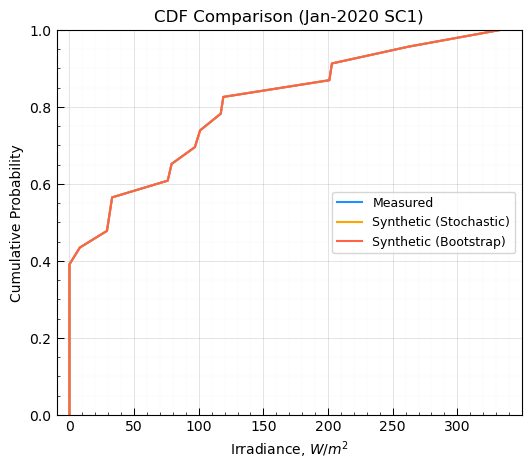

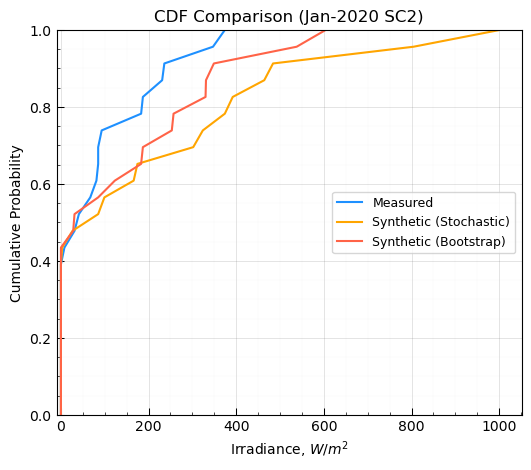

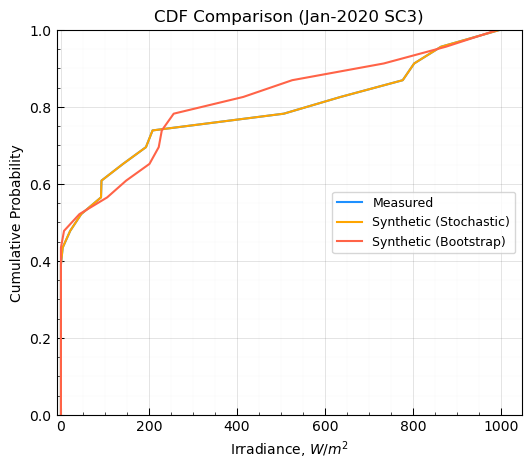

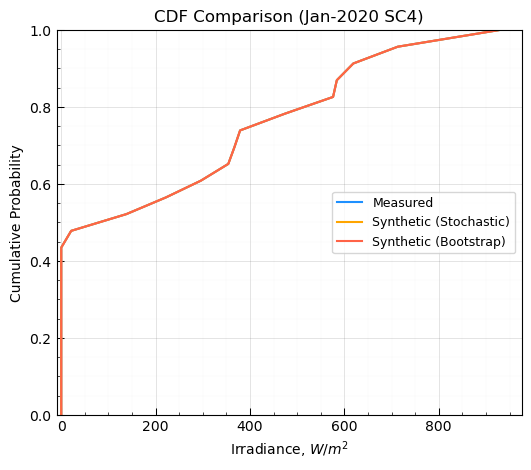

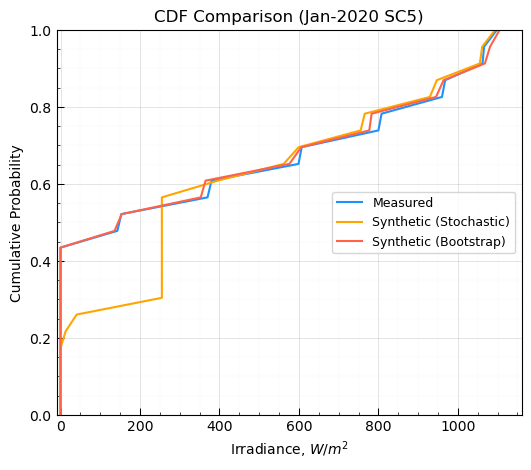

In [47]:
YY = 2020
MM = 'Jan'

for i in LOOP_SC:
    x, y = src.utils.cdf(data=LOOP_ANALYSIS[f'{MM}{YY}']['bootstrap'][i].T.sample(n=1, axis=1).iloc[:,0].values)
    xs, ys = src.utils.cdf(data=SYNTHETIC['stochastic'][f'{MM}{YY}-{i}'].sample(n=1, axis=1).iloc[:,0].values)
    xb, yb = src.utils.cdf(data=SYNTHETIC['bootstrap'][f'{MM}{YY}-{i}'].sample(n=1, axis=1).iloc[:,0].values)

    hor = 6
    ver = 5
    plt.figure(figsize=(hor,ver), dpi=100)

    plt.plot(x, y, color='dodgerblue', label='Measured')
    plt.plot(xs, ys, color='orange', label='Synthetic (Stochastic)')
    plt.plot(xb, yb, color='tomato', label='Synthetic (Bootstrap)')

    plt.title(f'CDF Comparison ({MM}-{YY} {str.upper(i)})')
    plt.ylabel('Cumulative Probability')
    plt.xlabel('Irradiance, $W/m^2$')
    plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
    plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(0, 1)
    plt.xlim(-10, None)
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
    plt.tight_layout
    plt.legend(loc='center right', fontsize=9) # bbox_to_anchor=(1,1)